In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'moving_fingers', 
    'shaking_hands'
]

data = np.concatenate([
    np.load('dataset/seq_moving_fingers_1697719566.npy'),
    np.load('dataset/seq_shaking_hands_1697719566.npy')
], axis=0)

data.shape

(1672, 30, 100)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1672, 30, 99)
(1672,)


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1672, 2)

In [7]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1504, 30, 99) (1504, 2)
(168, 30, 99) (168, 2)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 44130 (172.38 KB)
Trainable params: 44130 (172.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
42/47 [=========================>....] - ETA: 0s - loss: 10.4338 - acc: 0.7031
Epoch 1: val_acc improved from -inf to 0.75595, saving model to models/model.h5
47/47 [==============================] - 1s 10ms/step - loss: 10.0215 - acc: 0.6995 - val_loss: 4.6867 - val_acc: 0.7560 - lr: 0.0010
Epoch 2/200
25/47 [==============>...............] - ETA: 0s - loss: 5.9852 - acc: 0.6825

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/47 [============================>.] - ETA: 0s - loss: 8.5681 - acc: 0.6678
Epoch 2: val_acc did not improve from 0.75595
47/47 [==============================] - 0s 8ms/step - loss: 8.7293 - acc: 0.6669 - val_loss: 10.4792 - val_acc: 0.6726 - lr: 0.0010
Epoch 3/200
41/47 [=========================>....] - ETA: 0s - loss: 19.3865 - acc: 0.6921
Epoch 3: val_acc did not improve from 0.75595
47/47 [==============================] - 0s 7ms/step - loss: 24.4532 - acc: 0.6848 - val_loss: 89.0735 - val_acc: 0.5119 - lr: 0.0010
Epoch 4/200
41/47 [=========================>....] - ETA: 0s - loss: 62.8146 - acc: 0.6021
Epoch 4: val_acc improved from 0.75595 to 0.79762, saving model to models/model.h5
47/47 [==============================] - 0s 7ms/step - loss: 58.8730 - acc: 0.6270 - val_loss: 26.4250 - val_acc: 0.7976 - lr: 0.0010
Epoch 5/200
40/47 [========================>.....] - ETA: 0s - loss: 14.2639 - acc: 0.8109
Epoch 5: val_acc improved from 0.79762 to 0.83333, saving model to models

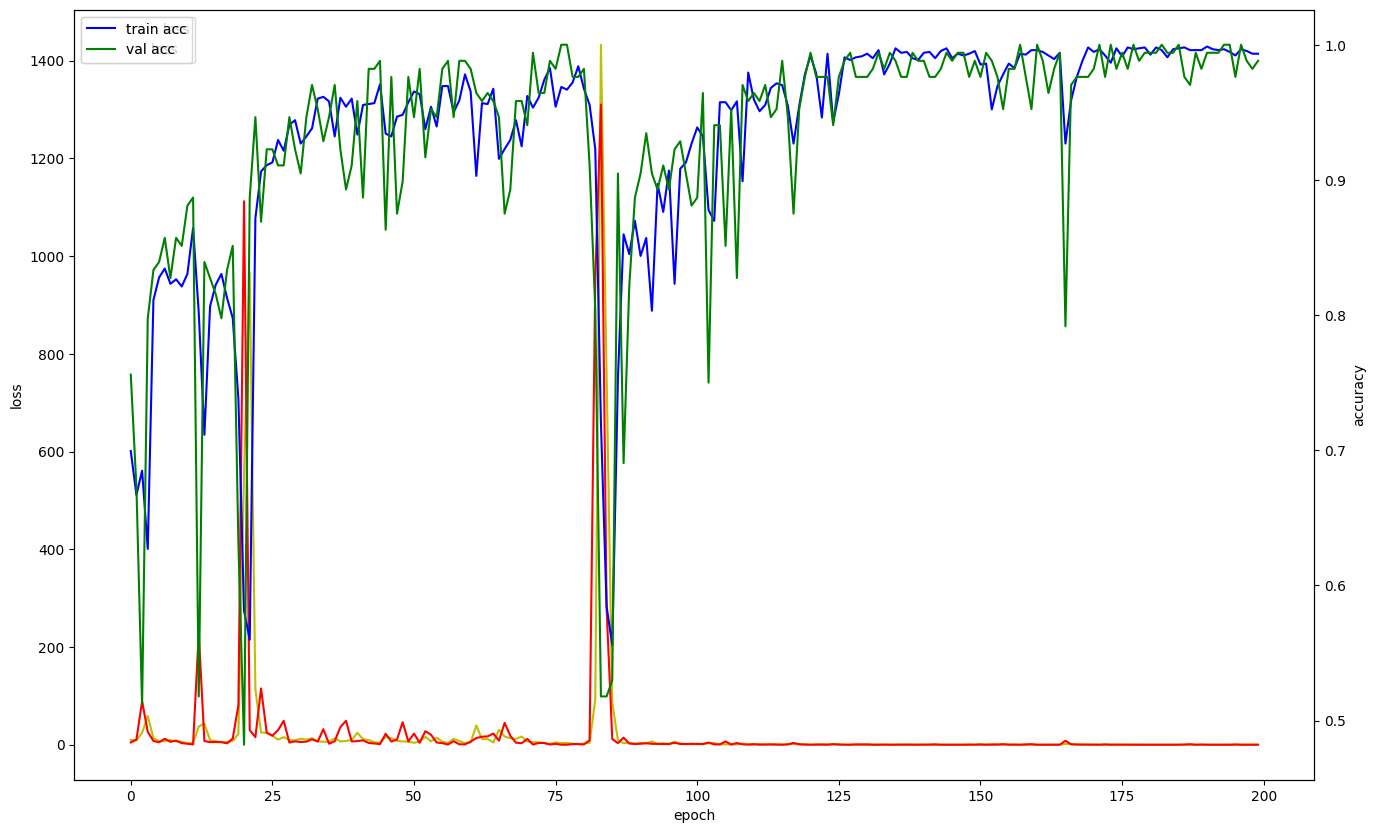

In [10]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [11]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

6/6 [==============================] - 0s 2ms/step


array([[[81,  0],
        [ 0, 87]],

       [[87,  0],
        [ 0, 81]]])